In [184]:
def mount_storage():
  import os
  import google.colab
  gdrive_dir = '/content/gdrive'
  google.colab.drive.mount(gdrive_dir)
  storage_dir = os.path.join(gdrive_dir,'My Drive/Colab Notebooks/manning_pose_estimation')
  return storage_dir

storage_dir = mount_storage()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [185]:
def download_and_unzip_from_s3(file_name, s3, bucket_name='fast-ai-coco'):
  import subprocess
  print("Downloading", file_name)
  s3.download_file(bucket_name, file_name, file_name)
  print("Finished downloading", file_name, ". Starting to unzip.")
  subprocess.run(["unzip", file_name])
  print("Finished unzipping", file_name)

def download_annotations():
  import boto3
  from botocore.client import Config
  from botocore import UNSIGNED
  s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
  download_and_unzip_from_s3('annotations_trainval2017.zip',s3)

download_annotations()

Finished downloading annotations_trainval2017.zip . Starting to unzip.
Finished unzipping annotations_trainval2017.zip


In [186]:
def take_photo(filename='photo.jpg', quality=0.8):
  from IPython.display import display, Javascript
  from google.colab.output import eval_js
  from base64 import b64decode

  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => {
        delay_ms = 5000;
        capture.onclick = (() => setTimeout(resolve, delay_ms));
      });

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

take_photo('photo.jpg')

<IPython.core.display.Javascript object>

'photo.jpg'

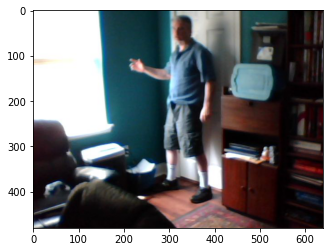

In [187]:
def load_image_from_file(image_path):
  import PIL
  image=PIL.Image.open(image_path)
  return image

def show_image(image):
  import matplotlib.pyplot as plt
  plt.imshow(image)

show_image(load_image_from_file('photo.jpg'))

In [188]:
def detect_objects(pil_image):
  import torchvision
  import torch
  import numpy as np
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  model.eval()
  #print('model='+str(model))
  np_image = np.array(pil_image)
  torch_image = torch.from_numpy(np_image)
  image_processed = torch_image.permute((2,0,1))
  image_processed = image_processed*(1/255.0)
  inputs = [image_processed]
  outputs = model(inputs)
  output = outputs[0]
  return output

image = load_image_from_file('photo.jpg')
object_detection_output = detect_objects(image)



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [189]:
#object_detection_output['boxes']
#object_detection_output['labels']
object_detection_output['scores']

tensor([0.9970, 0.9032, 0.8242, 0.8203, 0.8154, 0.7603, 0.7466, 0.6839, 0.6726,
        0.6663, 0.6572, 0.6529, 0.6190, 0.5521, 0.5467, 0.5240, 0.5060, 0.5015,
        0.4924, 0.4605, 0.4498, 0.4229, 0.4083, 0.3840, 0.3794, 0.3640, 0.3593,
        0.3439, 0.3327, 0.2960, 0.2700, 0.2663, 0.2531, 0.2455, 0.2334, 0.2315,
        0.2178, 0.2127, 0.2074, 0.2040, 0.1915, 0.1839, 0.1671, 0.1565, 0.1450,
        0.1446, 0.1432, 0.1428, 0.1391, 0.1389, 0.1268, 0.1259, 0.1237, 0.1143,
        0.1040, 0.0967, 0.0946, 0.0945, 0.0903, 0.0894, 0.0888, 0.0874, 0.0849,
        0.0845, 0.0823, 0.0822, 0.0816, 0.0812, 0.0804, 0.0715, 0.0684, 0.0673,
        0.0654, 0.0641, 0.0595, 0.0582, 0.0578, 0.0570, 0.0568, 0.0565, 0.0534,
        0.0500], grad_fn=<IndexBackward>)

keys=dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])
keys=dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])
label=person, score=0.9970121383666992


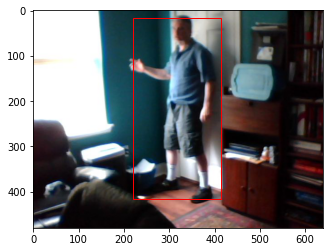

In [190]:
def make_categories():
  import json
  instances_val2017_json = json.load(open('annotations/instances_val2017.json'))
  categories = instances_val2017_json['categories']
  print('keys='+str(instances_val2017_json['annotations'][0].keys()))
  return categories

def make_category_names_by_id(categories):
  category_name_dict = dict((c['id'], c['name']) for c in categories)
  return category_name_dict

def find_category_id(category_name, category_names_by_id):
  id = next(id for id, name in category_names_by_id.items() if name==category_name)
  return id

def find_person_box(output):
  category_name = 'person'
  categories = make_categories()
  category_names_by_id = make_category_names_by_id(categories)
  person_id = find_category_id(category_name, category_names_by_id)
  for object_index in range(len(output['boxes'])):
    box = output['boxes'][object_index]
    id = int(output['labels'][object_index])
    if id == person_id:
      label = category_names_by_id[id]
      score = float(output['scores'][object_index])
      print('label=' + str(label) + ', score=' + str(score))
      return box

def draw_box_around_person(output, image):
  import matplotlib.pyplot as plt
  categories = make_categories()
  category_names_by_id = make_category_names_by_id(categories)
  figure = plt.imshow(image)
  box = find_person_box(output)
  x1,y1,x2,y2 = box
  x,y = x1,y1
  width, height = (x2-x1),(y2-y1)
  figure = plt.imshow(image)
  figure.axes.add_patch(plt.Rectangle((x,y),width,height,fill=False,color='Red'))
  return figure

draw_box_around_person(object_detection_output, image)

keys=dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])
label=person, score=0.9970121383666992


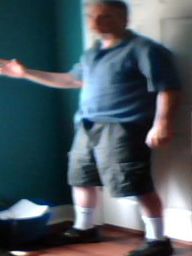

In [191]:
def crop_and_resize_image(image, crop, new_size):
  new_width, new_height = new_size
  crop_x, crop_y, crop_width, crop_height = crop
  image=image.crop((crop_x,crop_y,crop_x+crop_width,crop_y+crop_height))
  image=image.resize((new_width,new_height))
  return image

def make_crop(bbox):
  from math import floor, ceil
  bbox_x, bbox_y, bbox_width, bbox_height = bbox
  crop_x1=floor(bbox_x)
  crop_y1=floor(bbox_y)
  crop_x2=ceil(bbox_x+bbox_width)
  crop_y2=ceil(bbox_y+bbox_height)
  crop_width=crop_x2-crop_x1
  crop_height=crop_y2-crop_y1
  return crop_x1, crop_y1, crop_width, crop_height

def make_bbox(box):
  x1,y1,x2,y2 = map(float,box)
  bbox = (x1,y1,(x2-x1),(y2-y1))
  return bbox

def create_cropped_and_resized_image(image_pil, crop):
  cropped_image = crop_and_resize_image(image_pil, crop, (192, 256))
  return cropped_image

def cropped_and_resized_person_image(image, crop):
  return create_cropped_and_resized_image(image, crop)

crop = make_crop(make_bbox(find_person_box(object_detection_output)))
cropped_and_resized_image = cropped_and_resized_person_image(image, crop)
cropped_and_resized_image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading /content/gdrive/My Drive/Colab Notebooks/manning_pose_estimation/project_4.2_model.pickle


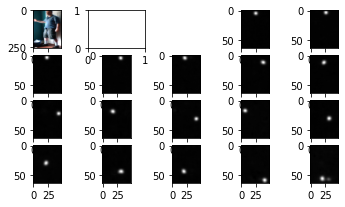

In [192]:
def prepare_image(image):
  import numpy as np
  image = np.array(image)
  assert image.shape[2] == 3
  image = image.astype('float32')/255
  mean = image.mean(axis=(0,1))
  std = image.std(axis=(0,1))
  desired_mean = (0.485, 0.456, 0.406)
  desired_std = (0.229, 0.224, 0.225)
  image = (image - mean)/std*desired_std + desired_mean
  image = np.float32(image)
  return image

def generate_keypoint_input(image):
  import numpy as np
  prepared_image = prepare_image(image)
  prepared_image = np.transpose(prepared_image, axes=(2,0,1))
  return prepared_image

def make_keypoint_detection_model_path(storage_dir):
  import os
  keypoint_detection_model_path = os.path.join(storage_dir,'project_4.2_model.pickle')
  return keypoint_detection_model_path

def make_keypoint_detection_model():
  import torch
  import torch.nn as nn
  from torch.hub import load_state_dict_from_url


  __all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
            'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
            'wide_resnet50_2', 'wide_resnet101_2']


  model_urls = {
      'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
      'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
      'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
      'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
      'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
      'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
      'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
      'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
      'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
  }


  def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
      """3x3 convolution with padding"""
      return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                      padding=dilation, groups=groups, bias=False, dilation=dilation)


  def conv1x1(in_planes, out_planes, stride=1):
      """1x1 convolution"""
      return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


  class BasicBlock(nn.Module):
      expansion = 1

      def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                  base_width=64, dilation=1, norm_layer=None):
          super(BasicBlock, self).__init__()
          if norm_layer is None:
              norm_layer = nn.BatchNorm2d
          if groups != 1 or base_width != 64:
              raise ValueError('BasicBlock only supports groups=1 and base_width=64')
          if dilation > 1:
              raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
          # Both self.conv1 and self.downsample layers downsample the input when stride != 1
          self.conv1 = conv3x3(inplanes, planes, stride)
          self.bn1 = norm_layer(planes)
          self.relu = nn.ReLU(inplace=True)
          self.conv2 = conv3x3(planes, planes)
          self.bn2 = norm_layer(planes)
          self.downsample = downsample
          self.stride = stride

      def forward(self, x):
          identity = x

          out = self.conv1(x)
          out = self.bn1(out)
          out = self.relu(out)

          out = self.conv2(out)
          out = self.bn2(out)

          if self.downsample is not None:
              identity = self.downsample(x)

          out += identity
          out = self.relu(out)

          return out


  class Bottleneck(nn.Module):
      # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
      # while original implementation places the stride at the first 1x1 convolution(self.conv1)
      # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
      # This variant is also known as ResNet V1.5 and improves accuracy according to
      # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

      expansion = 4

      def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                  base_width=64, dilation=1, norm_layer=None):
          super(Bottleneck, self).__init__()
          if norm_layer is None:
              norm_layer = nn.BatchNorm2d
          width = int(planes * (base_width / 64.)) * groups
          # Both self.conv2 and self.downsample layers downsample the input when stride != 1
          self.conv1 = conv1x1(inplanes, width)
          self.bn1 = norm_layer(width)
          self.conv2 = conv3x3(width, width, stride, groups, dilation)
          self.bn2 = norm_layer(width)
          self.conv3 = conv1x1(width, planes * self.expansion)
          self.bn3 = norm_layer(planes * self.expansion)
          self.relu = nn.ReLU(inplace=True)
          self.downsample = downsample
          self.stride = stride

      def forward(self, x):
          identity = x

          out = self.conv1(x)
          out = self.bn1(out)
          out = self.relu(out)

          out = self.conv2(out)
          out = self.bn2(out)
          out = self.relu(out)

          out = self.conv3(out)
          out = self.bn3(out)

          if self.downsample is not None:
              identity = self.downsample(x)

          out += identity
          out = self.relu(out)

          return out


  class ResNet(nn.Module):

      def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                  groups=1, width_per_group=64, replace_stride_with_dilation=None,
                  norm_layer=None, custom=False):
          super(ResNet, self).__init__()
          if norm_layer is None:
              norm_layer = nn.BatchNorm2d
          self._norm_layer = norm_layer
          self._custom = custom

          self.inplanes = 64
          self.dilation = 1
          if replace_stride_with_dilation is None:
              # each element in the tuple indicates if we should replace
              # the 2x2 stride with a dilated convolution instead
              replace_stride_with_dilation = [False, False, False]
          if len(replace_stride_with_dilation) != 3:
              raise ValueError("replace_stride_with_dilation should be None "
                              "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
          self.groups = groups
          self.base_width = width_per_group
          self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                                bias=False)
          self.bn1 = norm_layer(self.inplanes)
          self.relu = nn.ReLU(inplace=True)
          self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
          self.layer1 = self._make_layer(block, 64, layers[0])
          self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                        dilate=replace_stride_with_dilation[0])
          self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                        dilate=replace_stride_with_dilation[1])
          self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                        dilate=replace_stride_with_dilation[2])
          if not custom:
              self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
              self.fc = nn.Linear(512 * block.expansion, num_classes)
          else:
              self.conv_transpose = nn.Sequential(
                  nn.ConvTranspose2d(2048,256,kernel_size=4,stride=2,padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.ConvTranspose2d(256,256,kernel_size=4,stride=2,padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.ConvTranspose2d(256,256,kernel_size=4,stride=2,padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 17, kernel_size=5, padding=2, stride=1),
              )

          for m in self.modules():
              if isinstance(m, nn.Conv2d):
                  nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
              elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                  nn.init.constant_(m.weight, 1)
                  nn.init.constant_(m.bias, 0)

          # Zero-initialize the last BN in each residual branch,
          # so that the residual branch starts with zeros, and each residual block behaves like an identity.
          # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
          if zero_init_residual:
              for m in self.modules():
                  if isinstance(m, Bottleneck):
                      nn.init.constant_(m.bn3.weight, 0)
                  elif isinstance(m, BasicBlock):
                      nn.init.constant_(m.bn2.weight, 0)

      def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
          norm_layer = self._norm_layer
          downsample = None
          previous_dilation = self.dilation
          if dilate:
              self.dilation *= stride
              stride = 1
          if stride != 1 or self.inplanes != planes * block.expansion:
              downsample = nn.Sequential(
                  conv1x1(self.inplanes, planes * block.expansion, stride),
                  norm_layer(planes * block.expansion),
              )

          layers = []
          layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                              self.base_width, previous_dilation, norm_layer))
          self.inplanes = planes * block.expansion
          for _ in range(1, blocks):
              layers.append(block(self.inplanes, planes, groups=self.groups,
                                  base_width=self.base_width, dilation=self.dilation,
                                  norm_layer=norm_layer))

          return nn.Sequential(*layers)

      def _forward_impl(self, x):
          # See note [TorchScript super()]
          x = self.conv1(x)
          x = self.bn1(x)
          x = self.relu(x)
          x = self.maxpool(x)

          x = self.layer1(x)
          x = self.layer2(x)
          x = self.layer3(x)
          x = self.layer4(x)

          if not self._custom:
              x = self.avgpool(x)
              x = torch.flatten(x, 1)
              x = self.fc(x)
          else:
              x = self.conv_transpose(x)

          return x

      def forward(self, x):
          return self._forward_impl(x)


  def _resnet(arch, block, layers, pretrained, progress, **kwargs):
      model = ResNet(block, layers, **kwargs)
      if pretrained:
          state_dict = load_state_dict_from_url(model_urls[arch],
                                                progress=progress)
          model.load_state_dict(state_dict)
      return model


  def resnet18(pretrained=False, progress=True, **kwargs):
      r"""ResNet-18 model from
      `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

      Args:
          pretrained (bool): If True, returns a model pre-trained on ImageNet
          progress (bool): If True, displays a progress bar of the download to stderr
      """
      return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                    **kwargs)



  def resnet34(pretrained=False, progress=True, **kwargs):
      r"""ResNet-34 model from
      `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

      Args:
          pretrained (bool): If True, returns a model pre-trained on ImageNet
          progress (bool): If True, displays a progress bar of the download to stderr
      """
      return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                    **kwargs)



  def resnet50(pretrained=False, progress=True, **kwargs):
      r"""ResNet-50 model from
      `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

      Args:
          pretrained (bool): If True, returns a model pre-trained on ImageNet
          progress (bool): If True, displays a progress bar of the download to stderr
      """
      return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                    **kwargs)



  def resnet101(pretrained=False, progress=True, **kwargs):
      r"""ResNet-101 model from
      `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

      Args:
          pretrained (bool): If True, returns a model pre-trained on ImageNet
          progress (bool): If True, displays a progress bar of the download to stderr
      """
      return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                    **kwargs)



  def resnet152(pretrained=False, progress=True, **kwargs):
      r"""ResNet-152 model from
      `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

      Args:
          pretrained (bool): If True, returns a model pre-trained on ImageNet
          progress (bool): If True, displays a progress bar of the download to stderr
      """
      return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                    **kwargs)



  def resnext50_32x4d(pretrained=False, progress=True, **kwargs):
      r"""ResNeXt-50 32x4d model from
      `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_

      Args:
          pretrained (bool): If True, returns a model pre-trained on ImageNet
          progress (bool): If True, displays a progress bar of the download to stderr
      """
      kwargs['groups'] = 32
      kwargs['width_per_group'] = 4
      return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                    pretrained, progress, **kwargs)



  def resnext101_32x8d(pretrained=False, progress=True, **kwargs):
      r"""ResNeXt-101 32x8d model from
      `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_

      Args:
          pretrained (bool): If True, returns a model pre-trained on ImageNet
          progress (bool): If True, displays a progress bar of the download to stderr
      """
      kwargs['groups'] = 32
      kwargs['width_per_group'] = 8
      return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                    pretrained, progress, **kwargs)



  def wide_resnet50_2(pretrained=False, progress=True, **kwargs):
      r"""Wide ResNet-50-2 model from
      `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_

      The model is the same as ResNet except for the bottleneck number of channels
      which is twice larger in every block. The number of channels in outer 1x1
      convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
      channels, and in Wide ResNet-50-2 has 2048-1024-2048.

      Args:
          pretrained (bool): If True, returns a model pre-trained on ImageNet
          progress (bool): If True, displays a progress bar of the download to stderr
      """
      kwargs['width_per_group'] = 64 * 2
      return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                    pretrained, progress, **kwargs)



  def wide_resnet101_2(pretrained=False, progress=True, **kwargs):
      r"""Wide ResNet-101-2 model from
      `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_

      The model is the same as ResNet except for the bottleneck number of channels
      which is twice larger in every block. The number of channels in outer 1x1
      convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
      channels, and in Wide ResNet-50-2 has 2048-1024-2048.

      Args:
          pretrained (bool): If True, returns a model pre-trained on ImageNet
          progress (bool): If True, displays a progress bar of the download to stderr
      """
      kwargs['width_per_group'] = 64 * 2
      return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                    pretrained, progress, **kwargs)

  model = resnet50(custom = True)
  model_conv = model.cuda()
  keypoint_detection_model_path = make_keypoint_detection_model_path(storage_dir)
  print('loading '+str(keypoint_detection_model_path))
  model_conv.load_state_dict(torch.load(keypoint_detection_model_path))
  return model_conv

def show_input(input):
  import matplotlib.pyplot as plt
  import numpy as np
  plt.imshow(np.transpose(input, axes=(1,2,0)))

def make_keypoint_heatmaps(cropped_and_resized_image):
  import torch
  input = generate_keypoint_input(cropped_and_resized_image)
  show_input(input)
  inputs = torch.stack([torch.tensor(input)])
  model_conv = make_keypoint_detection_model()
  output = model_conv(inputs.cuda())[0].cpu().detach()
  return output

def show_keypoint_heatmaps(cropped_and_resized_image, output):
  import matplotlib.pyplot as plt
  n_rows = 5
  n_cols = 5
  plt.subplot(n_rows,n_cols, 1)
  plt.imshow(cropped_and_resized_image)
  plt.subplot(n_rows,n_cols, 2)
  n_keypoints = len(output)
  for keypoint_index in range(n_keypoints):
    keypoint_heatmap = output[keypoint_index]
    plt.subplot(n_rows,n_cols, 4+keypoint_index)
    plt.imshow(keypoint_heatmap,cmap='gray')

def show_image_shape(image_pil):
  import numpy as np
  print('shape='+str(np.array(image_pil).shape))

def show_model_summary(model):
  from torchsummary import summary
  summary(model, (3,256,192))

keypoint_heatmaps = make_keypoint_heatmaps(cropped_and_resized_image)
show_keypoint_heatmaps(cropped_and_resized_image, keypoint_heatmaps)
#np.array(cropped_and_resized_image).shape
#show_image_shape(cropped_and_resized_image)
#show_model_summary(make_keypoint_detection_model())


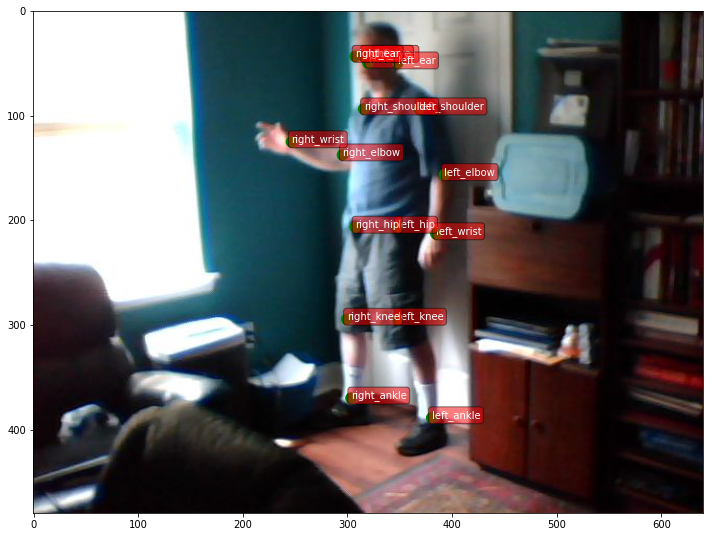

In [193]:
def find_keypoint(heatmap):
  import torch
  import numpy as np
  y,x = np.unravel_index(heatmap.argmax(), heatmap.shape)
  return x+0.5,y+0.5

def draw_keypoint(x,y,figure):
  import matplotlib.pyplot as plt
  circle=plt.Circle((x,y), radius=5, color='green')
  figure.axes.add_patch(circle)

def show_keypoint(heatmap):
  import matplotlib.pyplot as plt
  x,y = find_keypoint(heatmap)
  figure = plt.imshow(heatmap)
  draw_keypoint(x, y, figure)

def show_keypoint_on_original_image(figure, heatmap, crop, label):
  import matplotlib.pyplot as plt
  x,y = find_keypoint(heatmap)
  crop_x, crop_y, crop_width, crop_height = crop
  heatmap_height, heatmap_width = heatmap.shape
  original_x = crop_x + crop_width/heatmap_width*x
  original_y = crop_y + crop_height/heatmap_height*y
  draw_keypoint(original_x, original_y, figure)
  figure.axes.text(original_x,original_y,label,color='white',bbox=dict(facecolor='red', alpha=0.5, boxstyle='round'))


def find_person_keypoints(keypoint_data):
  categories=keypoint_data['categories']
  category=[c for c in categories if c['supercategory']=='person'][0]
  category_keypoints=category['keypoints']
  return category_keypoints

def make_person_keypoints():
  import json
  keypoint_data=json.load(open('annotations/person_keypoints_val2017.json'))
  keypoints = find_person_keypoints(keypoint_data)
  return keypoints

def show_keypoints_on_original_image(original_image, heatmaps, crop):
  import matplotlib.pyplot as plt
  person_keypoints = make_person_keypoints()
  n_keypoints = len(person_keypoints)
  figure = plt.figure(figsize=(12,12))
  figure = plt.imshow(original_image)
  for keypoint_index in range(n_keypoints):
    label = person_keypoints[keypoint_index]
    show_keypoint_on_original_image(figure, keypoint_heatmaps[keypoint_index], crop, label)

#find_keypoints(keypoint_heatmaps)
#show_keypoint(keypoint_heatmaps[7])
show_keypoints_on_original_image(image, keypoint_heatmaps, crop)
